In [1]:
# ===== Data Download and Extraction =====
import os
import zipfile

# Create .kaggle directory and set up credentials
os.makedirs('/root/.kaggle', exist_ok=True)
os.system('cp kaggle.json /root/.kaggle/')
os.system('chmod 600 /root/.kaggle/kaggle.json')

# Download dataset
os.system('kaggle datasets download -d salader/dogs-vs-cats')

# Extract dataset
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Set data paths
train_dir = '/content/train'
validation_dir = '/content/test'

# Verify directories
assert os.path.exists(train_dir), f"Training directory not found at {train_dir}"
assert os.path.exists(validation_dir), f"Validation directory not found at {validation_dir}"

In [2]:
# ===== Model Training Setup =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [3]:
# ===== VGG16 Model =====
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

vgg_model = create_vgg16_model()
vgg_model.summary()

history_vgg = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 303s 464ms/step - accuracy: 0.7613 - loss: 0.4806 - val_accuracy: 0.9130 - val_loss: 0.2164
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 299s 479ms/step - accuracy: 0.8754 - loss: 0.2882 - val_accuracy: 0.9156 - val_loss: 0.1995
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 284s 455ms/step - accuracy: 0.8866 - loss: 0.2642 - val_accuracy: 0.9212 - val_loss: 0.1865
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 300s 481ms/step - accuracy: 0.8901 - loss: 0.2491 - val_accuracy: 0.9256 - val_loss: 0.1867
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 453ms/step - accuracy: 0.8922 - loss: 0.2506 - val_accuracy: 0.9206 - val_loss: 0.1850
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 281s 450ms/step - accuracy: 0.8904 - loss: 0.2448 - val_accuracy: 0.9234 - val_loss: 0.1839
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 281s 450ms/step - accuracy: 0.8931 - loss: 0.2459 - val_accuracy: 0.9272 - val_loss: 0.1724
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 285s 457ms/step - accuracy: 0.9008 -

In [4]:
# ===== MobileNetV2 Model =====
def create_mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 251s 385ms/step - accuracy: 0.9513 - loss: 0.1195 - val_accuracy: 0.9780 - val_loss: 0.0554
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 377ms/step - accuracy: 0.9707 - loss: 0.0739 - val_accuracy: 0.9808 - val_loss: 0.0479
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 374ms/step - accuracy: 0.9743 - loss: 0.0659 - val_accuracy: 0.9810 - val_loss: 0.0482
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 375ms/step - accuracy: 0.9756 - loss: 0.0642 - val_accuracy: 0.9832 - val_loss: 0.0434
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 374ms/step - accuracy: 0.9769 - loss: 0.0593 - val_accuracy: 0.9796 - val_loss: 0.0508
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 237s 380ms/step - accuracy: 0.9770 - loss: 0.0587 - val_accuracy: 0.9786 - val_loss: 0.0528
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 233s 373ms/step - accuracy: 0.9767 - loss: 0.0609 - val_accuracy: 0.9784 - val_loss: 0.0519
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 375ms/step - accuracy: 0.9790 -

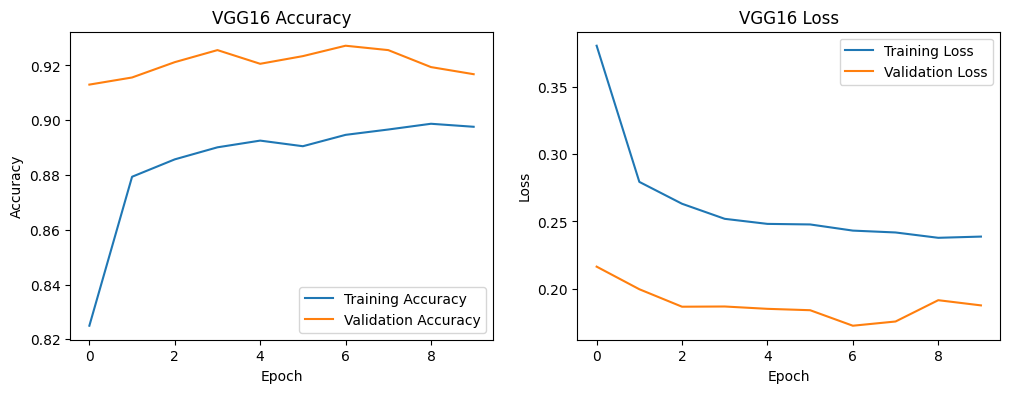

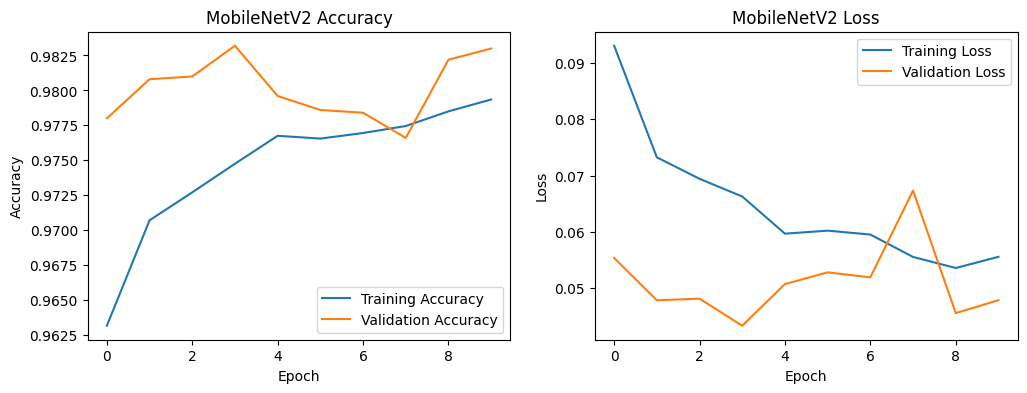

In [5]:
# ===== Visualization =====
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_vgg, 'VGG16')
plot_history(history_mobilenet, 'MobileNetV2')

# Save the best model
mobilenet_model.save('cats_dogs_mobilenet.h5')


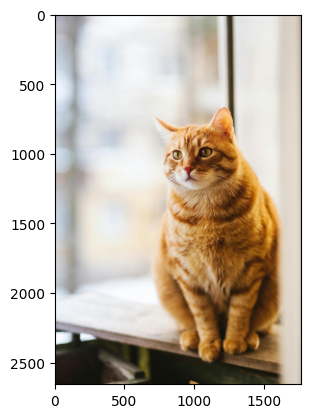

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Cat with confidence: 100.00%


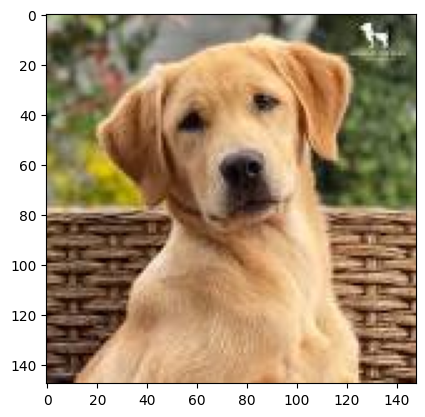

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction: Dog with confidence: 100.00%


array([[1.]], dtype=float32)

In [6]:
# ===== Prediction Example =====
def predict_image(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    img = cv2.resize(img, (224, 224))
    img = img.reshape((1, 224, 224, 3)) / 255.0

    prediction = model.predict(img)
    class_name = 'Dog' if prediction > 0.5 else 'Cat'
    confidence = float(prediction[0][0]) if prediction > 0.5 else 1 - float(prediction[0][0])

    print(f"Prediction: {class_name} with confidence: {confidence:.2%}")
    return prediction

# Test with sample images
predict_image(mobilenet_model, '/content/Cat_01.jpg')
predict_image(mobilenet_model, '/content/Dog_01.jpg')

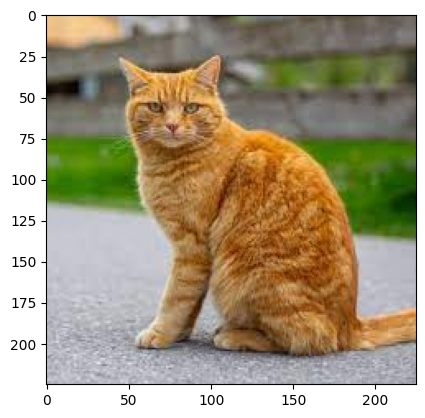

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: Cat with confidence: 99.91%


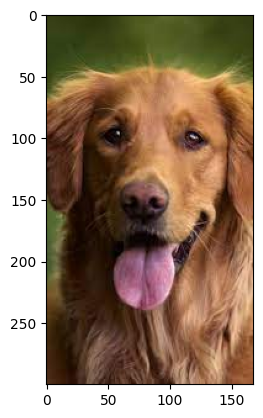

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: Dog with confidence: 100.00%


array([[0.9999995]], dtype=float32)

In [8]:
# ===== Prediction Example =====
def predict_image01(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    img = cv2.resize(img, (224, 224))
    img = img.reshape((1, 224, 224, 3)) / 255.0

    prediction = model.predict(img)
    class_name = 'Dog' if prediction > 0.5 else 'Cat'
    confidence = float(prediction[0][0]) if prediction > 0.5 else 1 - float(prediction[0][0])

    print(f"Prediction: {class_name} with confidence: {confidence:.2%}")
    return prediction

# Test with sample images
predict_image01(vgg_model, '/content/Cat_03.jpg')
predict_image01(vgg_model, '/content/Dog_03.jpg')